# DLC Live PyTorch Demo

In [2]:
%load_ext autoreload
%autoreload 2

In [1]:
from dlclive import DLCLive
import cv2
import numpy as np
from pathlib import Path
import time

Loading DLC 3.0.0rc4...
DLC loaded in light mode; you cannot use any GUI (labeling, relabeling and standalone GUI)


/home/dikra/miniconda3/envs/dlc-live/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### PyTorch to other runtimes

In [63]:
# In case you do not have a .onnx model exported, use this cell to export your DLC3.0 snapshot

from deeplabcut.pose_estimation_pytorch.config import read_config_as_dict
from deeplabcut.pose_estimation_pytorch.models import PoseModel
import torch
import onnxruntime as ort

device = "cuda" if torch.cuda.is_available() else "cpu"


#Dikra
root = Path("/home/dikra/MyHub/Code/DLC24_Hub/DLC_Experiments/super_bird_evaluate_tools")
model_cfg = read_config_as_dict(root / "superbird_hrnet_w32/train/pytorch_config.yaml")
weights_path = root / "superbird_hrnetw32_dlc3_parsed.pth"

#Anna
# root = Path("/Users/annastuckert/Documents/DLC_AI_Residency/DLC_AI2024/DeepLabCut-live/Ventral_gait_model/train")
# model_cfg = read_config_as_dict(root / "pytorch_config.yaml")
# weights_path = root / "snapshot-263.pt"

model = PoseModel.build(model_cfg["model"])
weights = torch.load(weights_path, map_location=device)
model.load_state_dict(weights["model"])

dummy_input = torch.zeros((1, 3, 224, 224))

torch.onnx.export(
    model,
    dummy_input,
    "/media/dikra/PhD/DATA/DLC24_Data/dlc-live-dummy/superbird/hrnet_w32.onnx",
    verbose=False,
    input_names=["input"],
    dynamic_axes={"input": {0: "batch_size", 2: "height", 3: "width"}},
)

/tmp/ipykernel_4604/1313231765.py:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  weights = torch.load(weights_path, map_location=device)


In [65]:
projects = ["fly-kevin", "hand-track", "superbird", "ventral-gait"]

# Load test frame
img = cv2.imread("/media/dikra/PhD/DATA/DLC24_Data/dlc-live-dummy/"+ projects[3] +"/img0006.png")

### DLC Live with ONNX exported DLC 3.0 model

In [67]:
# Dikra
onnx_dlc_live = DLCLive(
    path="/media/dikra/PhD/DATA/DLC24_Data/dlc-live-dummy/" + projects[3],
    model_type="onnx",
    device="cuda",
    display=True,
)

# Anna
# onnx_dlc_live = DLCLive(pytorch_cfg="/Users/annastuckert/Documents/DLC_AI_Residency/DLC_AI2024/DeepLabCut-live/Ventral_gait_model/train", processor=dlc_proc, snapshot='/Users/annastuckert/Documents/DLC_AI_Residency/DLC_AI2024/DeepLabCut-live/Ventral_gait_model/train/snapshot-263.pt')
# onnx_dlc_live = DLCLive("/Users/annastuckert/Documents/DLC_AI_Residency/DLC_AI2024/DeepLabCut-live/exported DLC model for dlc-live/DLC_dev-single-animal_resnet_50_iteration-1_shuffle-1", processor=dlc_proc)
# img = cv2.imread("/Users/annastuckert/Documents/DLC_AI_Residency/DLC_AI2024/DeepLabCut-live/exported DLC model for dlc-live/img049.png")

onnx_pose = onnx_dlc_live.init_inference(frame=img)
onnx_pose

Loading the model took 0.3057980537414551 sec
ONNX inference took 1.5952560901641846 sec
ONNX postprocessing took 0.0046672821044921875 sec


({'poses': tensor([[[[154.0191, 162.2270,   0.9150],
            [146.8835, 158.9902,   0.9459],
            [150.3471, 149.1086,   0.9092],
            [196.7142, 137.2174,   0.8844],
            [204.8947, 172.0168,   0.6791],
            [342.8763,  81.4389,   0.6930],
            [325.4101, 151.0740,   0.7804],
            [240.2777, 110.5351,   0.6488],
            [261.0042, 128.8401,   0.6075],
            [254.8745, 154.8118,   0.8237],
            [385.2757, 112.8775,   0.8098]]]])},
 1.5952560901641846)

![Screenshot from 2024-08-20 14-29-53.png](./docs/assets/Screenshot%20from%202024-08-20%2014-36-00.png)

In [6]:
onnx_pose = onnx_dlc_live.get_pose(frame=img)
onnx_pose

ONNX inference took 0.03652358055114746 sec
ONNX postprocessing took 0.004919767379760742 sec


{'poses': tensor([[[[154.0191, 162.2271,   0.9151],
           [146.8846, 158.9906,   0.9460],
           [150.3475, 149.1102,   0.9093],
           [196.7142, 137.2182,   0.8844],
           [204.8931, 172.0179,   0.6792],
           [342.8762,  81.4396,   0.6929],
           [325.4108, 151.0734,   0.7804],
           [240.2770, 110.5360,   0.6489],
           [261.0021, 128.8411,   0.6076],
           [254.8724, 154.8110,   0.8237],
           [385.2751, 112.8772,   0.8097]]]])}

In [68]:
onnx_dlc_live.display.destroy()

### DLC Live with snaptshot of DLC 3.0 model (.pt)

In [69]:
# Dikra
pytorch_dlc_live = DLCLive(
    path="/media/dikra/PhD/DATA/DLC24_Data/dlc-live-dummy/ventral-gait",
    snapshot="snapshot-263.pt",
    device="cuda",
    model_type="pytorch",
    display=True,
)

# Anna
# pytorch_dlc_live = DLCLive(pytorch_cfg="/Users/annastuckert/Documents/DLC_AI_Residency/DLC_AI2024/DeepLabCut-live/Ventral_gait_model/train", processor=dlc_proc, snapshot='/Users/annastuckert/Documents/DLC_AI_Residency/DLC_AI2024/DeepLabCut-live/Ventral_gait_model/train/snapshot-263.pt')
# pytorch_dlc_live = DLCLive("/Users/annastuckert/Documents/DLC_AI_Residency/DLC_AI2024/DeepLabCut-live/exported DLC model for dlc-live/DLC_dev-single-animal_resnet_50_iteration-1_shuffle-1", processor=dlc_proc)
# img = cv2.imread("/Users/annastuckert/Documents/DLC_AI_Residency/DLC_AI2024/DeepLabCut-live/exported DLC model for dlc-live/img049.png")

pytorch_pose = pytorch_dlc_live.init_inference(frame=img)
pytorch_pose

/home/dikra/MyHub/Code/DLC24_Hub/DLC_AI2024/DeepLabCut-live/dlclive/dlclive.py:257: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  weights = torch.load(model_path, map_locati

Loading the model took 0.4676992893218994 sec
PyTorch inference took 0.034587860107421875 sec
PyTorch postprocessing took 0.0018115043640136719 sec


({'poses': tensor([[[[154.0203, 162.2280,   0.9152],
            [146.8848, 158.9930,   0.9459],
            [150.3487, 149.1102,   0.9093],
            [196.7133, 137.2184,   0.8843],
            [204.8920, 172.0188,   0.6791],
            [342.8778,  81.4373,   0.6930],
            [325.4101, 151.0759,   0.7803],
            [240.2807, 110.5330,   0.6488],
            [261.0057, 128.8403,   0.6076],
            [254.8730, 154.8122,   0.8238],
            [385.2763, 112.8773,   0.8098]]]])},
 0.034587860107421875)

In [70]:
pytorch_dlc_live.display.destroy()

![PyTorch model inference](./docs/assets/Screenshot%20from%202024-08-20%2014-29-53.png)

### Which is faster?

In [72]:
import glob
import os

root = "/media/dikra/PhD/DATA/DLC24_Data/dlc-live-dummy/ventral-gait"
test_images = glob.glob(os.path.normpath(root + "/*.png"))


def mean_time_inference(dlc_live, images):
    times = []
    for i, img_p in enumerate(images):
        img = cv2.imread(img_p)

        if i == 0:
            start = time.time()
            dlc_live.init_inference(img)
            end = time.time()
        else:
            start = time.time()
            dlc_live.get_pose(img)
            end = time.time()
        times.append(end - start)
    print(times)

    return np.mean(times)

In [5]:
dlc_live = DLCLive(
    path="/media/dikra/PhD/DATA/DLC24_Data/dlc-live-dummy/ventral-gait",
    device="cuda",
    model_type="onnx",
    display=True,
)

mean_time = mean_time_inference(dlc_live, test_images)
print(
    f"TOTAL Inference of ONNX model took on average {mean_time} seconds for {len(test_images)} images"
)

Loading the model took 0.4884378910064697 sec
ONNX inference took 2.5211031436920166 sec
ONNX postprocessing took 0.0028717517852783203 sec
[3.2065136432647705]
TOTAL Inference of ONNX model took on average 3.2065136432647705 seconds for 1 images


In [19]:
dlc_live = DLCLive(
    path="/media/dikra/PhD/DATA/DLC24_Data/dlc-live-dummy",
    snapshot="snapshot-200.pt",
    device="cuda",
    model_type="pytorch"
)

mean_time = mean_time_inference(dlc_live, test_images) 
print(f"Inference of PyTorch model took on average {mean_time} seconds for {len(test_images)} images")

In [78]:
dlc_live = DLCLive(
    path="/media/dikra/PhD/DATA/DLC24_Data/dlc-live-dummy/" + projects[3],
    device="tensorrt",
    model_type="onnx"
)

mean_time = mean_time_inference(dlc_live, test_images) 
print(f"Inference of PyTorch model took on average {mean_time} seconds for {len(test_images)} images")

Loading the model took 4.69077205657959 sec
ONNX inference took 49.87957811355591 sec
ONNX postprocessing took 0.0015039443969726562 sec
[54.57309126853943]
Inference of PyTorch model took on average 54.57309126853943 seconds for 1 images


In [81]:
start = time.time()
dlc_live.get_pose(img)
end = time.time()

ONNX inference took 0.02220296859741211 sec
ONNX postprocessing took 0.0027968883514404297 sec


# Benchmarking

Currently the benchmark_pytorch.py script serves to provide a function for analyzing a preexisting video to test PyTorch for running video inference in DLC-Live. Code for running video inference on a live video feed is WIP.

For true benchmarking purposes, we aim to add feature for recording the time it takes to analyze each frame / how many frames can be analyzed per second. Discuss what measure to use and consult the DLC Live paper

In [7]:
from dlclive.benchmark_pytorch import analyze_video
from dlclive import DLCLive

dlc_live = DLCLive(
    path="/media/dikra/PhD/DATA/DLC24_Data/dlc-live-dummy/ventral-gait",
    device="tensorrt",
    snapshot="snapshot-263.pt",
    model_type="onnx",
    display=True,
)
#short video
# video_path = '/Users/annastuckert/Documents/DLC_AI_Residency/DLC_AI2024/DeepLabCut-live/Ventral_gait_model/1_20cms_0degUP_first_1s.avi'
video_path = "/media/dikra/PhD/DATA/DLC24_Data/dlc-live-dummy/ventral-gait/1_20cms_0degUP_first.avi"

poses, times = analyze_video(video_path=video_path, dlc_live=dlc_live, save_poses=False, save_dir="/media/dikra/PhD/DATA/DLC24_Data/dlc-live-dummy/ventral-gait/out", draw_keypoint_names=False)

ONNX inference took 0.1433417797088623 sec
ONNX postprocessing took 0.0010328292846679688 sec
ONNX inference took 0.019846677780151367 sec
ONNX postprocessing took 0.0009396076202392578 sec
ONNX inference took 0.01972174644470215 sec
ONNX postprocessing took 0.0011179447174072266 sec
ONNX inference took 0.019562959671020508 sec
ONNX postprocessing took 0.0027608871459960938 sec
ONNX inference took 0.02054119110107422 sec
ONNX postprocessing took 0.0019659996032714844 sec
ONNX inference took 0.019287586212158203 sec
ONNX postprocessing took 0.003919363021850586 sec
ONNX inference took 0.01930975914001465 sec
ONNX postprocessing took 0.0008289813995361328 sec
ONNX inference took 0.019775390625 sec
ONNX postprocessing took 0.0018341541290283203 sec
ONNX inference took 0.021361589431762695 sec
ONNX postprocessing took 0.004769325256347656 sec
ONNX inference took 0.020486831665039062 sec
ONNX postprocessing took 0.003214597702026367 sec
ONNX inference took 0.023508310317993164 sec
ONNX post

In [8]:
print("Mean inference time excluding 1st inference ", np.round(np.mean(times[1:])*1000, 2), "ms ±", np.round(np.std(times[1:])*1000, 2))
print("Mean inference time including 1st inference ", np.round(np.mean(times)*1000, 2), "ms ±", np.round(np.std(times)*1000, 2))

Mean inference time excluding 1st inference  20.72 ms ± 1.25
Mean inference time including 1st inference  20.8 ms ± 3.4


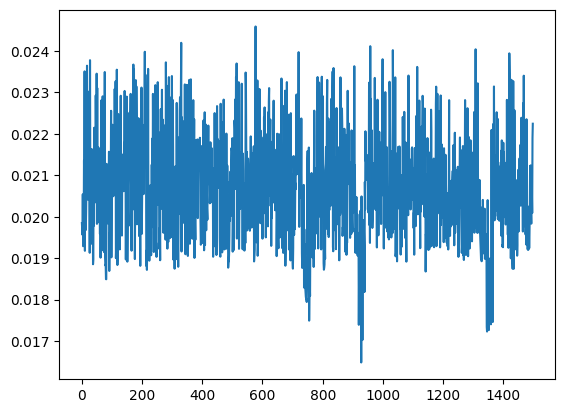

In [15]:
import matplotlib.pyplot as plt 

plt.plot(times[1:])

In [20]:
times

[0.1433417797088623,
 0.019846677780151367,
 0.01972174644470215,
 0.019562959671020508,
 0.02054119110107422,
 0.019287586212158203,
 0.01930975914001465,
 0.019775390625,
 0.021361589431762695,
 0.020486831665039062,
 0.023508310317993164,
 0.019176483154296875,
 0.022179841995239258,
 0.023015975952148438,
 0.019678354263305664,
 0.020087718963623047,
 0.020717859268188477,
 0.02086043357849121,
 0.023644685745239258,
 0.0215909481048584,
 0.02092742919921875,
 0.020411014556884766,
 0.023017406463623047,
 0.021517038345336914,
 0.021661043167114258,
 0.02132582664489746,
 0.02152848243713379,
 0.019128799438476562,
 0.02377772331237793,
 0.020733118057250977,
 0.021207809448242188,
 0.020865917205810547,
 0.01990199089050293,
 0.019349336624145508,
 0.02163100242614746,
 0.020320653915405273,
 0.020637989044189453,
 0.020346879959106445,
 0.01885223388671875,
 0.01897597312927246,
 0.02143716812133789,
 0.01978278160095215,
 0.022147655487060547,
 0.021617650985717773,
 0.021586656

In [1]:
import cv2

def get_video_characteristics(video_path):
    """
    Extracts the FPS, number of frames, length in seconds, and frame size of a video.

    Args:
        video_path (str): The path to the video file.

    Returns:
        tuple: A tuple containing the FPS, number of frames, length in seconds, and frame size.
    """

    cap = cv2.VideoCapture(video_path)

    # Get video properties
    fps = cap.get(cv2.CAP_PROP_FPS)
    frame_count = cap.get(cv2.CAP_PROP_FRAME_COUNT)
    frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

    # Calculate video length in seconds
    video_length = frame_count / fps

    cap.release()

    return fps, frame_count, video_length, (frame_width, frame_height)

# Example usage:
video_path = "/media/dikra/PhD/DATA/DLC24_Data/dlc-live-dummy/ventral-gait/1_20cms_0degUP_first.avi"
fps, frame_count, video_length, frame_size = get_video_characteristics(video_path)

print("FPS:", fps)
print("Number of frames:", frame_count)
print("Video length (seconds):", video_length)
print("Frame size:", frame_size)

FPS: 150.0
Number of frames: 1500.0
Video length (seconds): 10.0
Frame size: (658, 302)


In [21]:
import numpy as np

def calculate_fps_stats(inference_times):
    """
    Calculates the average FPS rate and its standard deviation from a list of inference times.

    Args:
        inference_times (list): A list of inference times in seconds.

    Returns:
        tuple: A tuple containing the average FPS rate and its standard deviation.
    """

    # Calculate FPS for each frame
    fps_values = [1 / time for time in inference_times]

    # Calculate average FPS
    average_fps = np.mean(fps_values)

    # Calculate standard deviation of FPS
    std_dev_fps = np.std(fps_values)

    return average_fps, std_dev_fps, fps_values

  # Replace with your actual inference times
average_fps, std_dev_fps, fps = calculate_fps_stats(times[1:])

print("Average FPS:", np.round((average_fps), 2))
print("Standard Deviation of FPS:", np.round((std_dev_fps), 2))

Average FPS: 48.43
Standard Deviation of FPS: 2.93


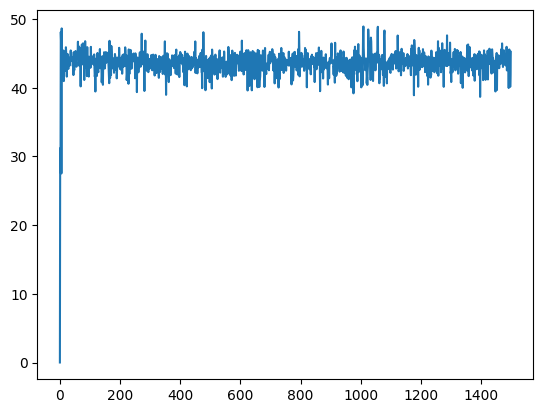

In [95]:
plt.plot(fps)

In [104]:
dlc_live.display.destroy()

In [103]:
dlc_live.sess.get_provider_options()

{'CPUExecutionProvider': {},
 'TensorrtExecutionProvider': {'trt_engine_hw_compatible': '0',
  'trt_ep_context_file_path': '',
  'trt_dump_ep_context_model': '0',
  'trt_cuda_graph_enable': '0',
  'trt_profile_opt_shapes': '',
  'trt_onnx_bytestream_size': '0',
  'trt_profile_min_shapes': '',
  'trt_onnx_bytestream': '0',
  'trt_extra_plugin_lib_paths': '',
  'trt_tactic_sources': '',
  'trt_builder_optimization_level': '3',
  'trt_dla_core': '0',
  'trt_engine_cache_path': '',
  'trt_int8_calibration_table_name': '',
  'trt_fp16_enable': '0',
  'trt_max_workspace_size': '0',
  'trt_int8_enable': '0',
  'trt_min_subgraph_size': '1',
  'trt_engine_decryption_lib_path': '',
  'trt_int8_use_native_calibration_table': '0',
  'trt_profile_max_shapes': '',
  'trt_timing_cache_enable': '0',
  'user_compute_stream': '0',
  'trt_onnx_model_folder_path': '',
  'trt_dump_subgraphs': '0',
  'trt_build_heuristics_enable': '0',
  'has_user_compute_stream': '0',
  'trt_max_partition_iterations': '100